In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

from scipy.integrate import quad
from functools import partial
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
import mpl_toolkits.mplot3d.axes3d as plt_3d
from Option_function import BSM 
import warnings
warnings.filterwarnings('ignore')
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

# Exotic Option

<font size=5 >*1.Introduction*</font>

I've presented a lot of notebook on traditional European vanilla options,and now I'd like to introduce more things relate to exotic options that are different but have broader practical applications, including Binary, Barrier, Asian and Bermuda Option.

<font size=5 >*2.Binary Options*</font>
## 2.1 Defination

A Binary Option is a financial exotic option in which the payoff is either some fixed monetary amount or nothing at all. 

It contains two kinds, one of which is a cash-or-nothing binary option and the other is asset-or-nothing binary option.

The former pays some fixed amount of cash if the option expires in the money while the latter pay the value of the underlying security. 

For more information you want to know, pls look at wikipedia

Let's review the Black-Scholes model, suppose the stock price follows a geometric Brownian motion, the Black-Scholes model can get the price of a vanilla European option.

$$ C (t, T, S_t, K, r, \sigma) = S_tN(d_1) - Ke^{-r(T-t)}N(d_2) $$

with

$$ d_1 = \frac{\log \biggl( \frac{S_t}{K}\biggr) + \biggl(r + \frac{\sigma^2}{2} \biggr) (T-t) }{\sigma \sqrt {T-t}}  \quad \mbox{and} \quad d_2=d_1 - \sigma \sqrt{T-t} $$

where _N_ is the cumulative distribution function (cdf) of a standard normal random variable. 
$$N(x)=\int_{-\infty}^{x}{\frac{1}{\sqrt{2\pi}}}e^{{-y^2}/2}{\rm d}y $$

The price of a vanilla call option (or put option) can be interpreted by decomposing a call option into an asset-or-nothing call option minus a cash-or-nothing call option, and similarly for a put – the binary options are easier to analyze, and correspond to the two terms in the Black–Scholes formula.

I don't know if you remember that $N(d_2)$, which is disscussed in the derivation of the Black-Scholes formula, is the probability that a vanilla call option finishes in the money under the risk-neutral measure. So its discounted values, $e^{-rt}N(d_2)$, is the price of Cash-or-nothing call option under the Black-Scholes model.

In conclude,  
- **Cash-or-Nothing Call**
$$Call = e^{-rT}N(d_2)$$
- **Cash-or-Nothing Put**
$$Put = e^{-rT}N(-d_2)$$
- **Asset-or-Nothing Call**
$$Call =Se^{-qT}N(d_1)$$
- **Asset-or-Nothing Call**
$$Put = Se^{-qT}N(d_1)$$

## 2.2 Code

### a) Closed Formula



In [24]:
def Binary_opt(S0,K,T,r,sigma,Type):
    d2=(np.log(S0/K)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))
    if Type == 'call':
        ret=np.exp(-r*T)*ss.norm.cdf(d2)
    elif Type == 'put':
        ret=np.exp(-r*T)*ss.norm.cdf(-d2)
    else:
        ret="Type Error"
    return ret

In [25]:
closed_binary=Binary_opt(100,100,1,0.1,0.2,'call')
print("The price of the ATM digital call option by closed formula is: ", closed_binary)

The price of the ATM digital call option by closed formula is:  0.5930501164033175


### b) Monte Carlo

In [26]:
def Binary_MC(S0,K,T,r,sigma,Type):
    N=10000000
    x=(r - sigma**2/2)*T + ss.norm.rvs(0,sigma,N)
    S=S0*np.exp(x)
    if Type == 'call':
        res = np.exp(-r*T)*np.mean(S>K)
    elif Type == 'put':
        res = np.exp(-r*T)*np.mean(S<K)
    else:
        ret="Type Error"
    return res

In [27]:
mc_binary=Binary_MC(100,100,1,0.1,0.2,'call')
print("The price of the ATM digital call option by Monte Carlo is: ", mc_binary)

The price of the ATM digital call option by Monte Carlo is:  0.5928171736013368


### c) PDE


In [38]:
def Binary_PDE(S0,K,T,r,sigma,Type):
    Nspace = 5000   # M space steps
    Ntime = 5000    # N time steps   
    S_max = 3*float(K)                
    S_min = float(K)/3
    x_max = np.log(S_max)  # A2
    x_min = np.log(S_min)  # A1

    x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)    # space discretization
    T_array, dt = np.linspace(0, T, Ntime, retstep=True)       # time discretization
    if Type == 'call':
        Payoff = np.where(np.exp(x)>K, 1, 0)          # Binary payoff
    elif Type == 'put':
        Payoff = np.where(np.exp(x)<K, 1, 0)          # Binary payoff
    V = np.zeros((Nspace,Ntime))       # grid initialization
    offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

    V[:,-1] = Payoff                   # terminal conditions 
    V[-1,:] = 1                        # boundary condition
    V[0,:] = 0                         # boundary condition

    # construction of the tri-diagonal matrix D
    sig2 = sig*sig; dxx = dx * dx
    a = ( (dt/2) * ( (r-0.5*sig2)/dx - sig2/dxx ) )
    b = ( 1 + dt * ( sig2/dxx + r ) )
    c = (-(dt/2) * ( (r-0.5*sig2)/dx + sig2/dxx ) )
    D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
    DD = splu(D)

    # Backward iteration
    for i in range(Ntime-2,-1,-1):
        offset[0] = a * V[0,i]
        offset[-1] = c * V[-1,i]; 
        V[1:-1,i] = DD.solve(V[1:-1,i+1] - offset)     

    # finds the option at S0
    oPrice = np.interp(X0, x, V[:,0])
    return oPrice

Text(0.5, 1.0, 'Curve at t=0')

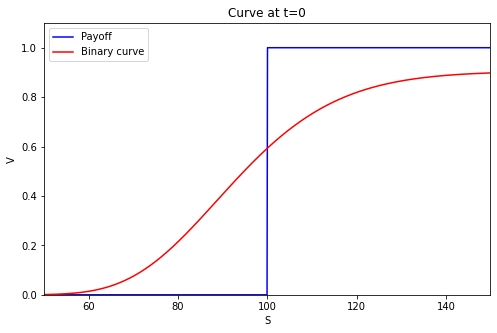

In [59]:
S = np.linspace(50,150,1000)
V=[Binary_opt(i,100,1,0.1,0.2,'call') for i in S]
Payoff = np.where(S>100, 1, 0)
plt.figure(figsize=(8,5))
plt.plot(S, Payoff, color='blue',label="Payoff")
plt.plot(S, V, color='red',label="Binary curve")
plt.xlim(50,150)
plt.ylim(0,1.1)
plt.xlabel("S")
plt.ylabel("V")
plt.legend(loc='upper left')
plt.title("Curve at t=0")

<font size=5 >*3.Asian Option*</font>
## 3.1 Defination

An Asian option (or average value option) is a special type of option contract. For Asian options the payoff is determined by the average underlying price over some pre-set period of time. This is different from the case of the usual European option and American option, where the payoff of the option contract depends on the price of the underlying instrument at exercise; Asian options are thus one of the basic forms of exotic options. There are two types of Asian options: fixed strike, where averaging price is used in place of underlying price; and fixed price, where averaging price is used in place of strike.

The most basic Asian Options are listed below:
- Fixed strike Asian call
$$C_T = max(A(0,T) - K, 0)$$
- Fixed strike Asian put
$$P_T = max(K - A(0,T), 0)$$
- Floating strike Asian call
$$C_T = max(S_T - KA(0,T), 0)$$
- Fixed strike Asian call
$$P_T = max(KA(0,T)- S_T, 0)$$

where $A(0,T)$ represent the average underlying price over a period of time.
In fact, there are two averaging algorithms that are very common  
- Arithmetic Average(Consinuous case)  
$$A(0,T)= \frac{1}{T}\int_{0}^{T}S(t){\rm d}t$$  
- Arithmetic Average(discrete case)  
$$A(0,T)=\frac{1}{n} \sum_{i=1}^{n}S(t_i)$$  
- Geometric Average(Consinuous case)  
$$A(0,T)=exp \biggl( \frac{1}{T}\int_{0}^{T}ln(S(t)) {\rm d}t \biggr)$$


## 3.2 Code

### a) Monte Carlo



In [64]:
def Fixed_MC_Asian(S0,K,r,T,sigma,Type):
    N=10000
    path=10000
    dt=T/(N-1)
    
    x0 = np.zeros((path,1))
    temp = ss.norm.rvs((r-sigma**2/2)*dt,sigma*np.sqrt(dt),size=(path,N-1))
    X = np.concatenate((x0,temp),axis=1).cumsum(1)
    S = S0*np.exp(X)
    
    Average=np.mean(S,axis=1)
    
    if Type == 'call':
        res=np.exp(-r*T)*np.mean(np.maximum(Average - K, 0))
    elif Type == 'put':
        res=np.exp(-r*T)*np.mean(np.maximum(K - Average, 0))
    else:
        res = 'Type Error'
        
    return res

In [65]:
Fixed_MC_Asian(100,100,0.1,1,0.2,'call')

7.068006371630977

In [67]:
def Float_MC_Asian(S0,K,r,T,sigma,Type):
    N=10000
    path=10000
    dt=T/(N-1)
    
    x0 = np.zeros((path,1))
    temp = ss.norm.rvs((r-sigma**2/2)*dt,sigma*np.sqrt(dt),size=(path,N-1))
    X = np.concatenate((x0,temp),axis=1).cumsum(1)
    S = S0*np.exp(X)
    
    Average=np.mean(S,axis=1)
    
    if Type == 'call':
        res=np.exp(-r * T) * np.mean( np.maximum( S[:,-1] - Average, 0 ) )
    elif Type == 'put':
        res=np.exp(-r * T) * np.mean( np.maximum( Average-S[:,-1], 0 ) )    
    else:
        res = 'Type Error'
        
    return res

In [68]:
Float_MC_Asian(100,100,0.1,1,0.2,'call')

7.149404443455857

### b) PDE
- Fixed strike

Considering the PDE:

$$ \frac{\partial  g(t,y)}{\partial t}+ \frac{1}{2} \sigma^2 \bigl(\gamma(t) - y\bigr)^2 \frac{\partial^2  g(t,y)}{\partial y^2}  = 0. $$

with boundary conditions:

$$ \begin{cases}g(T,y) = y^+ \\ g(t, -\infty) =0\\ g(t,y) \underset{y\to \infty}{\sim} y \\\gamma(t) := \frac{1}{rT} (1 - e^{-r(T-t)})\end{cases}$$

The solution of this PDE:

$$ V(t,a,s) := s \, g \bigg(t,\frac{x}{s} \bigg) $$

with 
$$x := \frac{1}{rT} \bigl( 1-e^{-rT} \bigr) s - e^{-rT} K $$

We can discretize the computational domain and call $g(t_n, y_i) := g^n_i$, and then discretize the PDE using the usual implicit method (for a review, see the notebook **2.1**). We obtain:

$$ g^{n+1}_{i} = a^{n}_{i}\, g^{n}_{i-1} + b^{n}_{i}\, g^{n}_{i} + a^{n}_{i}\, g^{n}_{i+1} $$

with

$$\begin{cases}
 a^{n}_{i} =  - \frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta y^2}  \biggl(\gamma(t_n) - y_i \biggr)^2 \\ b^{n}_{i} = 1 + \sigma^2 \frac{\Delta t}{\Delta y^2} \biggl(\gamma(t_n) - y_i \biggr)^2 \end{cases}$$

- Floating  strike

Since the whole proof process is too tedious, I won't give a full explanation here. If you are interested, you can check the corresponding books.



In [80]:
def gamma(t,T,r,sigma):
    res=1/(r*T) * ( 1 - np.exp(-r*(T-t)) )
    return res

def X_0(S0,K,r,T,sigma):
    res=gamma(0,T,r,sigma)*S0-np.exp(-r*T)*K
    return res
def Fixed_PDE_Asian(S0,K,r,T,sigma):
    step=5000
    time=5000
    y_max=60
    y_min=-60
    
    y, dy = np.linspace(y_min, y_max, Nspace, retstep=True)    # space discretization
    T_array, dt = np.linspace(0, T, Ntime, retstep=True)       # time discretization
    Payoff = np.maximum(y,0)                                   # payoff 

    G = np.zeros((Nspace,Ntime))       # grid initialization
    offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

    G[:,-1] = Payoff                   # terminal conditions 
    G[-1,:] = y_max                    # boundary condition
    G[0,:] = 0                         # boundary condition

    for n in range(Ntime-2,-1,-1):

        # construction of the tri-diagonal matrix D
        sig2 = sig*sig; dyy = dy * dy
        a = -0.5 * (dt/dyy) * sig2 * (gamma(T_array[n],T,r,sigma) - y[1:-1])**2 
        b = 1 + (dt/dyy) * sig2 * (gamma(T_array[n],T,r,sigma) - y[1:-1])**2      # main diagonal
        a0 = a[0]; cM = a[-1]                                           # boundary terms
        aa = a[1:]; cc = a[:-1]                                         # upper and lower diagonals 
        D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()

        # backward computation
        offset[0] = a0 * G[0,n]
        offset[-1] = cM * G[-1,n]; 
        G[1:-1,n] = spsolve( D, (G[1:-1,n+1] - offset) )

    X0 = X_0(S0,K,r,T,sigma)
    oPrice = S0 * np.interp(X0/S0, y, G[:,0])
    return oPrice
def Float_PDE_Asian(S0,K,r,T,sigma):
    Nspace = 4000   # M space steps
    Ntime = 7000    # N time steps   
    x_max = 10      # A2
    x_min = 0       # A1
    x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)    # space discretization
    T_array, dt = np.linspace(0.0001, T, Ntime, retstep=True)  # time discretization
    Payoff = np.maximum(x-1,0)                                 # Call payoff

    V = np.zeros((Nspace,Ntime))       # grid initialization
    offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   
    V[:,-1] = Payoff                   # terminal conditions 
    V[-1,:] = x_max-1                  # boundary condition
    V[0,:] = 0                         # boundary condition

    for n in range(Ntime-2,-1,-1):

        # construction of the tri-diagonal matrix D
        sig2 = sig*sig; dxx = dx * dx
        max_part = np.maximum( x[1:-1] * (r - (x[1:-1] - 1)/T_array[n] ), 0 )        # upwind positive part
        min_part = np.minimum( x[1:-1] * (r - (x[1:-1] - 1)/T_array[n] ), 0 )        # upwind negative part

        a = min_part * (dt/dx)  - 0.5 * (dt/dxx) * sig2 * (x[1:-1])**2 
        b = 1 + dt*( r - (x[1:-1] - 1)/T_array[n] ) + (dt/dxx) * sig2 * (x[1:-1])**2 \
                   + dt/dx * (max_part - min_part)                                      # main diagonal
        c = -max_part * (dt/dx) - 0.5 * (dt/dxx) * sig2 * (x[1:-1])**2 

        a0 = a[0]; cM = c[-1]     # boundary terms
        aa = a[1:]; cc = c[:-1]   # upper and lower diagonals 
        D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()     # matrix D

        # backward computation
        offset[0] = a0 * V[0,n]
        offset[-1] = cM * V[-1,n]; 
        V[1:-1,n] = spsolve( D, (V[1:-1,n+1] - offset) )   

    # finds the option at S0, assuming it is ATM i.e. x=s/a=1
    oPrice = S0 * np.interp(1, x, V[:,0])
    return oPrice

In [70]:
Float_PDE_Asian(100,100,0.1,1,0.2)

7.300526237510499

In [81]:
Fixed_PDE_Asian(100,100,0.1,1,0.2)

7.0508906916853284

<font size=5 >*4.Barrier Option*</font>
## 4.1 Defination

A barrier option is an option whose payoff is conditional upon the underlying asset's price breaching a barrier level during the option's lifetime. 

Barrier options are path-dependent exotics that are similar in some ways to ordinary options. You can call or put in American, Bermudan, or European exercise style. But they become activated (or extinguished) only if the underlying breaches a predetermined level (the barrier).

"In" options only become active in the event that a predetermined knock-in barrier price is breached:

- If the barrier price is far from being breached, the knock-in option will be worth slightly more than zero.
- If the barrier price is close to being breached, the knock-in option will be worth slightly less than the corresponding vanilla option.
- If the barrier price has been breached, the knock-in option will trade at the exact same value as the corresponding vanilla option.  

"Out" options start their lives active and become null and void in the event that a certain knock-out barrier price is breached:

- If the barrier price is far from being breached, the knock-out option will be slightly less than the corresponding vanilla option.
- If the barrier price is close to being breached, the knock-out option will be worth slightly more than zero.
- If the barrier price has been breached, the knock-out option will trade at the exact value of zero.

In general, ther are fout main types of barrier options,   
- **Up-and-out**
$$C(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ (S_T - K)^+ \mathbb{1}_{\{M_T < B\}} \, \big| \, S_t=s \bigr]$$
$$P(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ (K - S_T)^+ \mathbb{1}_{\{M_T < B\}} \, \big| \, S_t=s \bigr]$$
- **Down-and-out**
$$C(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ (S_T - K)^+ \mathbb{1}_{\{\tilde M_T < B\}} \, \big| \, S_t=s \bigr]$$
$$P(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ (K - S_T)^+ \mathbb{1}_{\{\tilde M_T < B\}} \, \big| \, S_t=s \bigr]$$
- **Up-and-in**
$$C(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ (S_T - K)^+ \mathbb{1}_{\{M_T > B\}} \, \big| \, S_t=s \bigr]$$
$$P(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ (K - S_T)^+ \mathbb{1}_{\{M_T > B\}} \, \big| \, S_t=s \bigr]$$
- **Down-and-in**
$$C(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ (S_T - K)^+ \mathbb{1}_{\{\tilde M_T > B\}} \, \big| \, S_t=s \bigr]$$
$$P(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ (K - S_T)^+ \mathbb{1}_{\{\tilde M_T > B\}} \, \big| \, S_t=s \bigr]$$

with:  
$$M_t = \max_{0\leq t \leq T} S_t.$$
$$\tilde M_t = \min_{0\leq t \leq T} S_t.$$

## 4.2 In-out parity

We have the following parity relations between the prices of barrier options and vanilla call and put options:

$$ \begin{cases}
C_{up-in}(t) + C_{up-out}(t) = e^{-(T-t)r}\mathbb{E}^{Q}[(S_T - K)^{+} \big{|} F_t] = C_{European}
\\C_{down-in}(t) + C_{down-out}(t) = e^{-(T-t)r}\mathbb{E}^{Q}[(S_T - K)^{+} \big{|} F_t] = C_{European}
\\P_{up-in}(t) + P_{up-out}(t) = e^{-(T-t)r}\mathbb{E}^{Q}[(K - S_T)^{+} \big{|} F_t] = P_{European}
\\P_{down-in}(t) + P_{down-out}(t) = e^{-(T-t)r}\mathbb{E}^{Q}[(K - S_T)^{+} \big{|} F_t]  = P_{European}
\end {cases}$$

## 4.3 Formula and Code
In this section, I will show you the formulas and codes w.r.t 4 different main kinds barrier option.

### a) Up-and-out barrier call option

Let us consider an up-and-out barrier call optin with maturity T, strike price K, barrier B, and payoff (B $\geq $ K)
$$C = (S_T - K)^+ \mathbb{1}_{\{M_T < B\}} = \begin{cases} S_T - K \qquad{if \space \mathop{max}\limits_{0\leq t \leq T}} S_t \leq B\\0\qquad\qquad\quad{if \space \mathop{max}\limits_{0\leq t \leq T}} B \leq S_t\end{cases} $$

the price of the up-and-out barrier call option:

$$e^{-(T-t)r}\mathbb{E}^{Q}\biggl[(S_T - K)^{+} \mathbb{1}_{\{M^{T}_0 < B\}} \big| \mathcal F_t\biggr]$$
$$=S_t \mathbb{1}_{\{M^{T}_0 < B\}}\biggl\{\Phi\biggl( \delta_{+}^{T-t}\biggl(\frac{S_t}{K}\biggr)\biggr) - \Phi\biggl( \delta_{+}^{T-t}\biggl(\frac{S_t}{B}\biggr)\biggr)$$

$$-\biggl(\frac{B}{S_t}\biggr)^{1+\frac{2r}{\sigma^2}}\biggl(\Phi\biggl( \delta_{+}^{T-t}\biggl(\frac{B^2}{KS_T}\biggr)\biggr) - \Phi\biggl( \delta_{+}^{T-t}\biggl(\frac{B}{S_t}\biggr)\biggr) \biggr)\biggr\}$$

$$-e^{-r(T-t)}K\mathbb{1}_{\{M^{T}_0 < B \}}\biggl\{\Phi\biggl( \delta_{-}^{T-t}\biggl(\frac{S_t}{K}\biggr)\biggr) - \Phi\biggl( \delta_{-}^{T-t}\biggl(\frac{S_t}{B}\biggr)\biggr)$$

$$-\biggl(\frac{S_t}{B}\biggr)^{1+\frac{2r}{\sigma^2}}\biggl(\Phi\biggl( \delta_{-}^{T-t}\biggl(\frac{B^2}{KS_T}\biggr)\biggr) - \Phi\biggl( \delta_{-}^{T-t}\biggl(\frac{B}{S_t}\biggr)\biggr) \biggr)\biggr\}$$

where
$$\delta^{\tau}_{\pm} = \frac{1}{\sigma\sqrt{\tau}}\biggl(\log{s} + (r \pm \frac{\sigma^2}{2})\tau\biggr)$$

### b) Up-and-out barrier put option
- if $B \leq K$
$$e^{-(T-t)r}\mathbb{E}^{Q}\biggl[(K - S_T)^{+} \mathbb{1}_{\{M^{T}_0 < B\}} \big|  \mathcal F_t\biggr]$$
$$=S_t\mathbb{1}_{\{M^{T}_0 < B\}}\biggl(\Phi\biggl(\delta^{T-t}_{+}\biggl(\frac{S_t}{B}\biggr) \biggr)-1-\biggl(\frac{B}{S_t}\biggr)^{1+\frac{2r}{\sigma^{2}}} \biggl(\Phi\biggl(\delta^{T-t}_{+}\biggl(\frac{B}{S_t}\biggr)\biggr)-1\biggr)\biggr)$$

$$-e^{-r(T-t)}K\mathbb{1}_{\{M^{T}_0 < B\}}\biggl(\Phi\biggl(\delta^{T-t}_{-}\biggl(\frac{S_t}{B}\biggr) \biggr)-1-\biggl(\frac{B}{S_t}\biggr)^{1-\frac{2r}{\sigma^{2}}} \biggl(\Phi\biggl(\delta^{T-t}_{-}\biggl(\frac{B}{S_t}\biggr)\biggr)-1\biggr)\biggr)$$

- if $K \leq B$
$$e^{-(T-t)r}\mathbb{E}^{Q}\biggl[(K - S_T)^{+} \mathbb{1}_{\{M^{T}_0 < B\}} \big|  \mathcal F_t\biggr]$$
$$=S_t\mathbb{1}_{\{M^{T}_0 < B\}}\biggl(\Phi\biggl(\delta^{T-t}_{+}\biggl(\frac{S_t}{K}\biggr) \biggr)-1-\biggl(\frac{B}{S_t}\biggr)^{1+\frac{2r}{\sigma^{2}}} \biggl(\Phi\biggl(\delta^{T-t}_{+}\biggl(\frac{B^2}{KS_t}\biggr)\biggr)-1\biggr)\biggr)$$

$$-e^{-r(T-t)}K\mathbb{1}_{\{M^{T}_0 < B\}}\biggl(\Phi\biggl(\delta^{T-t}_{-}\biggl(\frac{S_t}{K}\biggr) \biggr)-1-\biggl(\frac{B}{S_t}\biggr)^{1-\frac{2r}{\sigma^{2}}} \biggl(\Phi\biggl(\delta^{T-t}_{-}\biggl(\frac{B^2}{KS_t}\biggr)\biggr)-1\biggr)\biggr)$$

### c) Down-and-out barrier call option
Let us consider an down-and-out barrier call optin with maturity T, strike price K, barrier B, and payoff ( $0\leq B \leq K$ )
$$C = (S_T - K)^+ \mathbb{1}_{\{\tilde{M_T} < B\}} = \begin{cases} S_T - K \qquad{if \space \mathop{min}\limits_{0\leq t \leq T}} S_t > B\\0\qquad\qquad\quad{if \space \mathop{min}\limits_{0\leq t \leq T}} S_t \leq B\end{cases} $$

the price of the up-and-out barrier call option:
- if $B\leq K$
$$e^{-(T-t)r}\mathbb{E}^{Q}\biggl[(S_T - K)^{+} \mathbb{1}_{\{ \mathop{min}\limits_{0\leq t \leq T}S_t > B\}} \big| \space\mathcal F_t\biggr]$$
$$=S_t\mathbb{1}_{\{M^{T}_0 > B\}}\Phi\biggl(\delta^{T-t}_{+}\biggl(\frac{S_t}{K}\biggr) \biggr)-e^{-r(T-t)}K\mathbb{1}_{\{M^{T}_0 > B\}}\Phi\biggl(\delta^{T-t}_{-}\biggl(\frac{S_t}{K}\biggr) \biggr)$$

$$-B\mathbb{1}_{\{M^{T}_0 > B\}}\biggl(\frac{B}{S_t}\biggr)^{\frac{2r}{\sigma^2}}\Phi\biggl(\delta^{T-t}_{+}\biggl(\frac{B^2}{KS_t}\biggr) \biggr)+e^{-r(T-t)}K\mathbb{1}_{\{M^{T}_0 > B\}}\biggl(\frac{S_t}{B}\biggr)^{1-\frac{2r}{\sigma^2}}\Phi\biggl(\delta^{T-t}_{-}\biggl(\frac{B^2}{KS_t}\biggr) \biggr)$$

- if $B\geq K$
$$e^{-(T-t)r}\mathbb{E}^{Q}\biggl[(S_T - K)^{+} \mathbb{1}_{\{ \mathop{min}\limits_{0\leq t \leq T}S_t > B\}} \big| \space\mathcal F_t\biggr]$$
$$=S_t\mathbb{1}_{\{M^{T}_0 > B\}}\Phi\biggl(\delta^{T-t}_{+}\biggl(\frac{S_t}{B}\biggr) \biggr)-e^{-r(T-t)}K\mathbb{1}_{\{M^{T}_0 > B\}}\Phi\biggl(\delta^{T-t}_{-}\biggl(\frac{S_t}{B}\biggr) \biggr)$$

$$-B\mathbb{1}_{\{M^{T}_0 > B\}}\biggl(\frac{B}{S_t}\biggr)^{\frac{2r}{\sigma^2}}\Phi\biggl(\delta^{T-t}_{+}\biggl(\frac{B}{S_t}\biggr) \biggr)+e^{-r(T-t)}K\mathbb{1}_{\{M^{T}_0 > B\}}\biggl(\frac{S_t}{B}\biggr)^{1-\frac{2r}{\sigma^2}}\Phi\biggl(\delta^{T-t}_{-}\biggl(\frac{B}{S_t}\biggr) \biggr)$$

### d) Down-and-out barrier put option
- if $B \leq K$
$$e^{-(T-t)r}\mathbb{E}^{Q}\biggl[(K - S_t)^{+} \mathbb{1}_{\{ \mathop{min}\limits_{0\leq t \leq T}S_t > B\}} \big| \space\mathcal F_t\biggr]$$

$$e^{-(T-t)r}\mathbb{E}^{Q}\biggl[(S_T - K)^{+} \mathbb{1}_{\{M^{T}_0 < B\}} \big| \mathcal F_t\biggr]$$
$$=S_t \mathbb{1}_{\{M^{T}_0 > B\}}\biggl\{\Phi\biggl( \delta_{+}^{T-t}\biggl(\frac{S_t}{K}\biggr)\biggr) - \Phi\biggl( \delta_{+}^{T-t}\biggl(\frac{S_t}{B}\biggr)\biggr)$$

$$-\biggl(\frac{B}{S_t}\biggr)^{1+\frac{2r}{\sigma^2}}\biggl(\Phi\biggl( \delta_{+}^{T-t}\biggl(\frac{B^2}{KS_T}\biggr)\biggr) - \Phi\biggl( \delta_{+}^{T-t}\biggl(\frac{B}{S_t}\biggr)\biggr) \biggr)\biggr\}$$

$$-e^{-r(T-t)}K\mathbb{1}_{\{M^{T}_0 > B \}}\biggl\{\Phi\biggl( \delta_{-}^{T-t}\biggl(\frac{S_t}{K}\biggr)\biggr) - \Phi\biggl( \delta_{-}^{T-t}\biggl(\frac{S_t}{B}\biggr)\biggr)$$

$$-\biggl(\frac{S_t}{B}\biggr)^{1+\frac{2r}{\sigma^2}}\biggl(\Phi\biggl( \delta_{-}^{T-t}\biggl(\frac{B^2}{KS_T}\biggr)\biggr) - \Phi\biggl( \delta_{-}^{T-t}\biggl(\frac{B}{S_t}\biggr)\biggr) \biggr)\biggr\}$$

while the price vanishes when  $K \leq B$

### d) Down-and-in and Up-and-in barrier  option
For every in option, we can use in-out parity to get the answer, and if you want to understand more detailed mathematics, I  recommend you to read related books


In [37]:
def Up_Out_Call(S,K,r,T,sigma,B):
    delta_positive=lambda x:(np.log(x) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    delta_negative=lambda x:(np.log(x) + (r - sigma**2/2)*T)/(sigma*np.sqrt(T))
    temp = S * ( ss.norm.cdf( delta_positive(S/K) ) - ss.norm.cdf( delta_positive(S/B) ) ) \
          - np.exp(-r*T) * K * ( ss.norm.cdf( delta_negative(S/K) ) - ss.norm.cdf( delta_negative(S/B) ) ) \
          - B * (S/B)**(-2*r/sigma**2) * ( ss.norm.cdf( delta_positive(B**2/(S*K) ) ) - ss.norm.cdf( delta_positive(B/S) ) ) \
          + np.exp(-r*T) * K * (S/B)**(-2*r/sig**2 + 1) * \
          ( ss.norm.cdf( delta_negative(B**2/(S*K) ) ) - ss.norm.cdf( delta_negative(B/S) ) )
    return temp

In [33]:
S=90
K=100
B=120
T=1
r=0.01
sigma=0.1

In [38]:
Up_Out_Call(S,K,r,T,sigma,B)

0.7651321464054976

### MonteCarlo Simulation:

In [39]:
N = 10000
paths = 50000
dt = T/(N-1)          # time interval

#path generation
X_0 = np.zeros((paths,1))
increments = ss.norm.rvs(loc=(r-sig**2/2)*dt, scale=np.sqrt(dt)*sig, size=(paths,N-1))
X = np.concatenate((X_0,increments), axis=1).cumsum(1)
St = S * np.exp(X)

M = np.amax(St, axis=1)       # maximum of each path
MM = np.amin(St, axis=1)      # minimum of each path

# Up and Out   --  Discounted expected payoff
MC_barrier_u = np.exp(-r * T) * (np.maximum( St[:,-1] - K, 0 ) @ (M<B) )/ paths

print("The price of the Up and Out call option by Monte Carlo is: ", MC_barrier_u)


The price of the Up and Out call option by Monte Carlo is:  0.7744439787972124
